# Ex02

#### Objective: Print the mean, median, min, max, first, second and third quartile of the price of the items purchased


In [219]:
# First of all, we have to import the necessary libraries
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Now we have to lconnect with the database in order to load the data

In [220]:
DB_NAME = "piscineds"
USER = "ojimenez"
PASSWORD = "mysecretpassword"
HOST = "localhost"
PORT = "5432"

# Let's connect with a SQLAlchemy engine (With psycopg2 we have a Warning):
engine_url = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}"
engine = create_engine(engine_url)

try:
    with engine.connect() as connection:
        print("Connected to the database successfully!")
except Exception as e:
    print(f"Error connecting to the database: {e}")


Connected to the database successfully!


#### Now we are ready to start with queries:

We are interested in the price of the rows where event_type is "purchase"

In [221]:
query = """
    SELECT  price
    FROM customers
    WHERE event_type = 'purchase';
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()

Query executed successfully :)


We have to print the different values: 


In [222]:
# We compute the descriptive statistics:

# Disable scientific notation for Pandas
pd.set_option('display.float_format', '{:.2f}'.format)
stats = data['price'].describe(percentiles=[0.25, 0.5, 0.75])

# We don't want the last line
stats_dict = stats.to_dict()
for key, value in stats_dict.items():
    print(f"{key}: {value:.2f}")

count: 1284648.00
mean: 4.93
std: 8.93
min: -79.37
25%: 1.59
50%: 3.00
75%: 5.40
max: 327.78


Now, we plot the graphics:

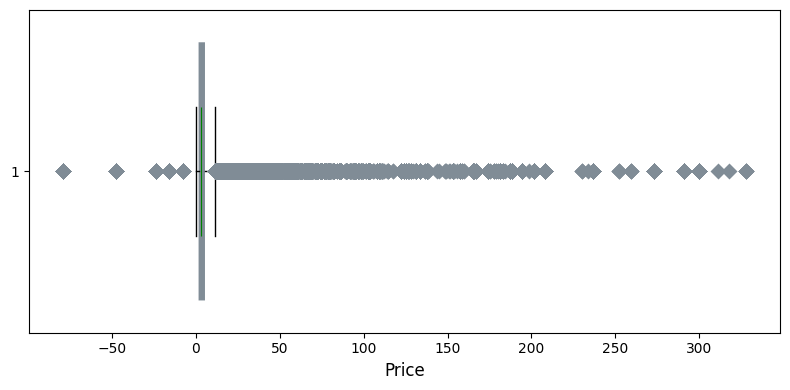

In [223]:
featured_color = (128 / 255, 140 / 255, 150 / 255)

plt.figure(figsize=(8, 4))
plt.boxplot(
    data['price'],
    vert=False, # Para que salga horizontal
    widths=0.8,
    notch=True,
    patch_artist=True,  # Relleno de las cajas
    boxprops=dict(facecolor=featured_color, edgecolor='none'),  # Color de las cajas
    flierprops=dict(marker='D', markersize=8, markerfacecolor=featured_color, markeredgecolor='none'),  # Estilo de outliers
    medianprops=dict(linestyle='-', linewidth=0.8, color='green')  # Resaltar la mediana
)

'''for patch in boxplot['boxes']:
    patch.set_facecolor('grey')
for median in boxplot['medians']:
    median.set_color('black')'''

plt.xlabel("Price", fontsize=12)
plt.xticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

Let's create the next one:

Info: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html#matplotlib.axes.Axes.boxplot

-4.125000000000001 11.115000000000002


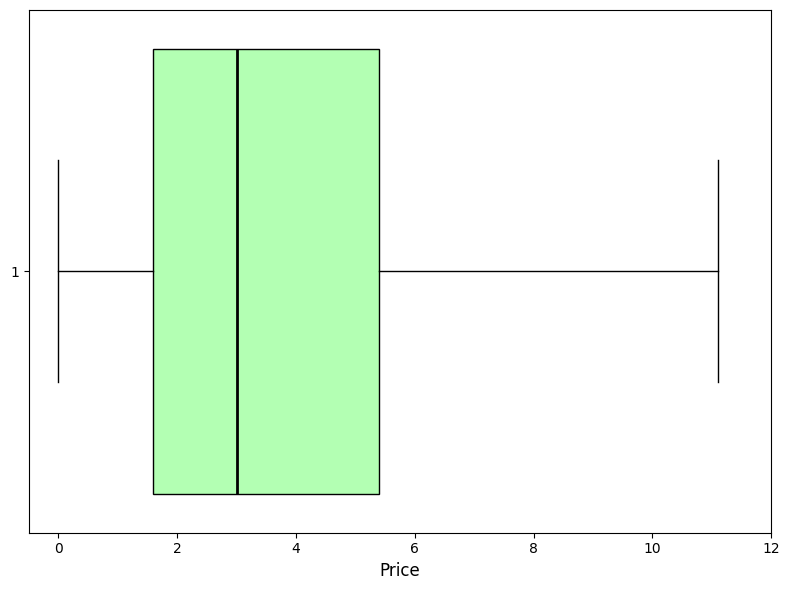

In [224]:
plt.figure(figsize=(8, 6))

Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)


boxplot = plt.boxplot(
    data['price'],
    vert=False,          # Horizontal orientation
    patch_artist=True,
    widths=0.85,
    showfliers=False,
    boxprops=dict(facecolor='green', edgecolor='black'),
    medianprops=dict(linestyle='-', linewidth=2, color='black')
)

for patch in boxplot['boxes']:
    patch.set_facecolor((0.7, 1.0, 0.7))
for median in boxplot['medians']:
    median.set_color('black')

plt.xlabel("Price", fontsize=12)
#plt.xlim(lower_bound - 1, upper_bound + 1)
plt.xlim(-0.5, 12)
plt.tight_layout()
plt.show()

#### The last spet is plot a box plot with the average basket price per user


In [225]:
# Puede que tenga que ser por comanda hecha asi que compra realizada el mismo dia a la misma hora por un mismo usuario
query = """
    SELECT 
        user_session,
        SUM(price) AS total_basket_price,
        COUNT(*) AS num_items_in_basket
    FROM 
        customers
    WHERE 
        event_type = 'purchase'
    GROUP BY 
        user_session
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()

Query executed successfully :)


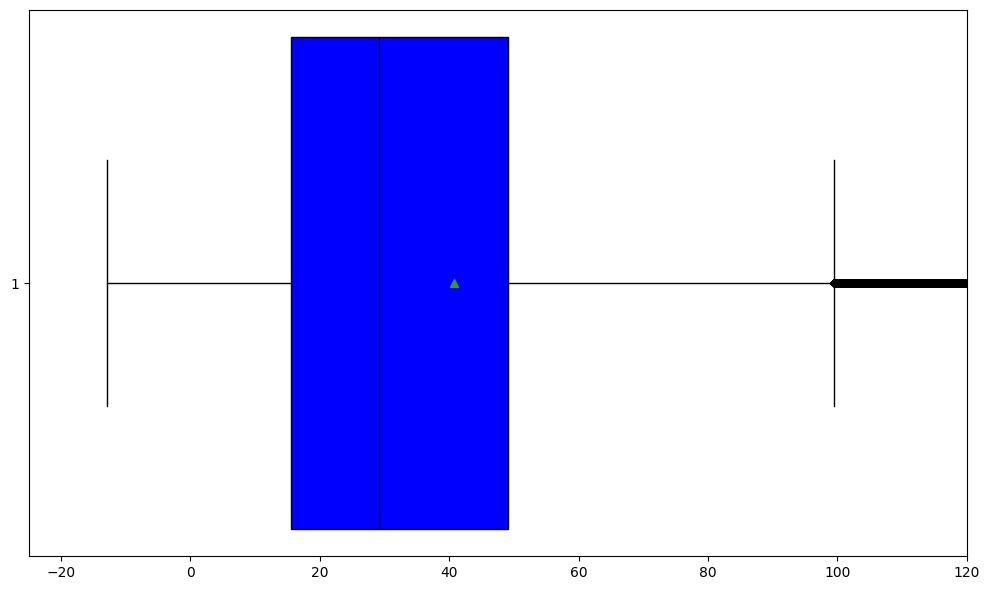

In [226]:
# We have to group by user_id:
basket = (
    data.groupby('user_session')
        .agg(total_price=('total_basket_price', 'sum'), num_purchases=('total_basket_price', 'count'))
        .reset_index()
)
# The function applies aggregation functions (sum, mean, count, min, max,...)

basket['average_basket_price'] = basket['total_price'] / basket['num_purchases']

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
    basket['average_basket_price'],
    vert=False,          # Horizontal orientation
    patch_artist=True,   # Enable custom styling
    widths=0.9,          # Adjust the width of the box
    boxprops=dict(linewidth=1.0),
    whiskerprops=dict(linewidth=1.0),
    capprops=dict(linewidth=1.0),
    flierprops=dict(marker='D', markersize=4, markerfacecolor='black', markeredgecolor='black', alpha=0.5),
    showmeans=True       # Show the mean value
)

for patch in boxplot['boxes']:
    patch.set_facecolor(('blue'))
for median in boxplot['medians']:
    median.set_color('black')


#plt.xlim(lower_bound - 1, upper_bound + 1)
plt.xlim(-25, 120)
plt.tight_layout()
plt.show()

## Other

In [227]:
# Puede que tenga que ser por comanda hecha asi que compra realizada el mismo dia a la misma hora por un mismo usuario
query = """
    SELECT user_id, AVG(price) AS avg_cart_price
    FROM customers
    WHERE event_type = 'cart'
    GROUP BY user_id
    HAVING AVG(price) BETWEEN 25 AND 43;
"""

try:
    data = pd.read_sql(query, engine)
    print("Query executed successfully :)")
except Exception as e:
    print(f"Error: {e}")
finally:
    engine.dispose()

Query executed successfully :)


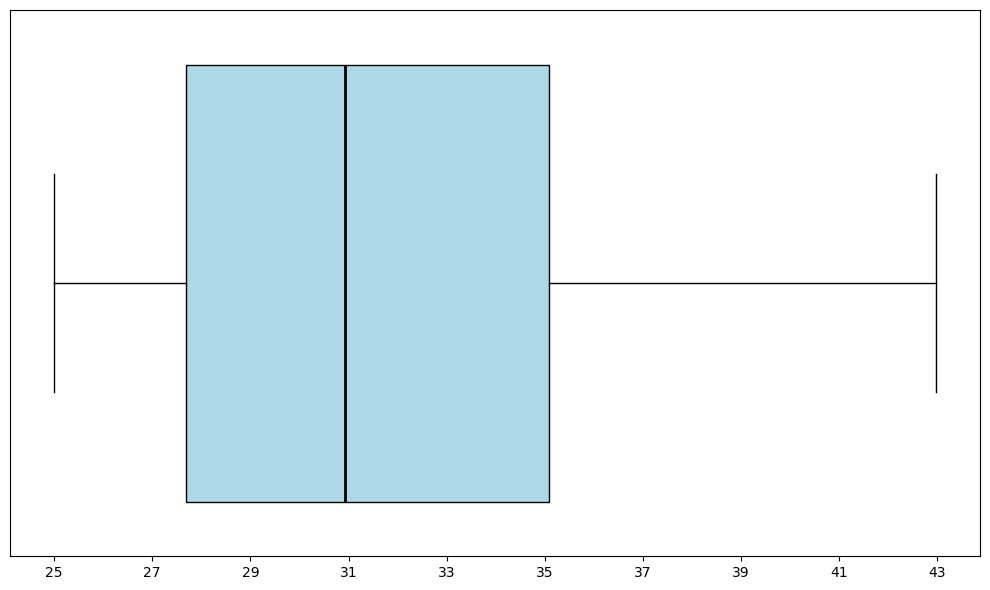

In [228]:
without_nan = data.dropna()

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.boxplot(
        without_nan['avg_cart_price'],
        vert=False,  # Horizontal
        widths=0.8,  # Ancho de las cajas
        patch_artist=True,  # Relleno de las cajas
        boxprops=dict(facecolor='lightblue', edgecolor='black'),  # Color de las cajas
        medianprops=dict(linestyle='-', linewidth=2, color='black'),  # Resaltar la mediana
        flierprops=dict(marker='D', markersize=8, markerfacecolor='lightgray', markeredgecolor='none')  # Estilo de outliers
)
plt.xticks(range(int(min(data['avg_cart_price'])), int(max(data['avg_cart_price'])) + 2, 2))
plt.yticks([])  # Eliminar etiquetas del eje y
plt.tight_layout()  # Ajustar diseño para evitar solapamientos
    
    # Mostrar el gráfico
plt.show()